In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import os
from collections import deque
from scipy.stats import linregress
from collections import deque, Counter

# Variables

In [43]:
# Constants
calibration_vals = [2080,2100,2200,2400,3000,3500,4000,4095] # eVOLVER PWM vals (in calibrate.py)
fit_name = "lightcal_20240410"
vial_nums = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
file_format = 'L{}.txt'

# Variables for Data Handling and Cleaning
path = os.getcwd()
indexname = "Sample Number"
valname = "Sensor Value"
zeroThreshold = 40 # noise threshold to take as the 'zero' of the light probe; anything above this counts as a reading
min_length = 500 # minimum number of indices in for it to count as a valid subset (500hz is sample rate, so 500 = 1 second)
probeSaturated = 10645 # the value on the light probe at which it gets saturated and won't go higher

# Variables for Plot Generation
printAllPlots = False # whether to print all plots, used for troubleshooting
medvalname = 'Median Sensor Value'
eVvalname = 'eVOLVER PWM Value'
savePlots = True # whether to save plots
saveFolder = 'analysis'
if saveFolder not in os.listdir():
    os.mkdir(saveFolder)
savePath = os.path.join(path,saveFolder)
saveType = '.pdf'

# Functions

In [45]:
def subsetByIndex(df, threshold_var, threshold, num_subsets, subset_labels, min_length=20, break_length=10, reverse=True):
    """
    Filters a dataframe by a threshold variable, then creates subsets of the filtered indices
    threshold_var = variable to filter by
    threshold = value to filter by
    num_subsets = number of subsets to create
    min_length = minimum number of indices in for it to count as a valid subset
    break_length = number of indices that counts as a break between each subset
    reverse = whether to label subsets starting from the back of the dataframe

    Returns the dataframe labelled by subset; parts that are not in a subset get filtered out
    """
    # Filter the dataframe by the threshold variable and value
    filtered_df = df[df[threshold_var] > threshold]
    
    # Find subsets in the filtered indices
    indices = filtered_df.index.tolist()
    subsets = {} # format: {subset_count: [indices]}
    subset_count = 0 # keep track of which subset we're on
    for i, indexNum in enumerate(indices): # iterate through each point
        if subset_count not in subsets:
            subsets[subset_count] = []

        if indexNum == indices[-1]: #avoid out of range erroring on the last row
            break
        if indices[i + 1] >= indexNum + break_length: # if the indexes skip after this one
            subset_count += 1 # start a new subset
        else:
            subsets[subset_count].append(indexNum) # add the index to the current subset

    # Give a warning if the number of subsets is not equal to the desired number    
    if num_subsets != len(subsets):
        print(f"Warning: num_subsets was set to {num_subsets}, but {len(subsets)} subsets were found.")
        if reverse:
            print("Keeping subset labels in reverse order.")
            subset_labels = subset_labels[-len(subsets):] # remove subset labels from the front of the labels list
        else:
            print("Keeping subset labels in forward order.")
            subset_labels = subset_labels[:len(subsets)] # remove subset labels from the back of the labels list
        plt.plot(indices, filtered_df[threshold_var], 'o')
        plt.title(f"{threshold_var} > {threshold}")
        plt.show()

    # Only keep subsets that are long enough 
    subset_indices = []
    for key in list(subsets.keys()):
        if len(subsets[key]) >= min_length:
            subset_indices += subsets[key]

    # Keep only the indices that belong to a subset
    filtered_df = filtered_df.loc[subset_indices]

    # Map each index to its subset label
    index_label_mapping = {}
    for subset_key, indices in subsets.items(): # Loop over the subsets to assign labels
        label = subset_labels[subset_key]  # Get the label for this subset
        for index in indices:
            index_label_mapping[index] = label  # Map index to label

    # Map the labels to the DataFrame
    # This assumes the DataFrame index aligns with the original DataFrame's filtered indices
    filtered_df[eVvalname] = filtered_df.index.map(index_label_mapping).fillna('No Label')

    return filtered_df

# Example usage:
# Assuming 'df' is your DataFrame, 'valname' is the column to filter by,
# 'zeroThreshold' is the threshold value, and you want 3 subsets.
# subsetByIndex(rawDF, threshold_var=valname, threshold=zeroThreshold, num_subsets=len(calibration_vals), subset_labels=calibration_vals,
#                     min_length=20, reverse=True) # add subset column; start from highest values and go down

In [46]:
def plotGrid(df, subset, subset_names, xVar, yVar, subRows, title='', hue=None):
    """
    iterates through the unique members of the "variable", plots members in a grid
    df = dataframe containing "var" in variables column, 
    """
    """
    Creates a grid of line plots for different subsets of data within a dataframe.

    This function iterates through the unique values of a specified subset variable in the dataframe. 
    It then creates a grid of line plots, each corresponding to one of these unique values. The 
    function allows customization of various plot elements such as the title, hue, and subplot 
    dimensions.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the data to be plotted.
    subset (str): The column name in the dataframe which contains the categorical variable 
                  used to create separate line plots.
    xVar (str): The column name in the dataframe to be used as the x-axis variable.
    yVar (str): The column name in the dataframe to be used as the y-axis variable.
    subRows (int): The number of rows in the subplot grid.
    title (str, optional): The title for the entire grid of plots. Defaults to an empty string.
    hue (str, optional): The column name in the dataframe to be used for color encoding. 
                         Defaults to None.

    Returns:
    None: This function does not return anything but creates and displays a grid of line plots.

    Raises:
    AttributeError: If certain plot customizations are not applicable to the generated plot type.

    Example:
    >>> plotGrid(df=my_dataframe, subset='category', xVar='time', yVar='value', subRows=2, 
                 title='Category Trends', hue='type')
    This will create a grid of line plots from 'my_dataframe', with separate plots for each unique 
    value in the 'category' column, plotted against 'time' and 'value', with 2 rows in the subplot 
    grid and color encoding based on 'type'.
    """
    unique = list(Counter(df[subset]).keys())
    graphCount = len(unique) # number of unique members of the variable
    subColumns = round(graphCount / subRows)
    
    # making the figure with locations
    scale = 3
    if subRows == 1:
        figsize = (scale * graphCount, scale)
    else:
        figsize = (scale * subColumns, scale * subRows)
    fig, axes = plt.subplots(subRows, subColumns, sharex=False, sharey=False,
                             figsize=figsize, dpi=150)
    
    ### Making plots on each of the sub locations
    for i, ax  in enumerate(axes.flat):
        if i >= graphCount: # skip if the index is out of range
            continue
        
        # titling the subplot
        subtitle = f'PWM Value {subset_names[i]}'
        ax.set_title(subtitle)
        
        #plotting
        subDF = df[df[subset] == unique[i]]
        x = subDF[xVar]
        y = subDF[yVar]
        ax = sns.lineplot(ax=ax, data=subDF, x=xVar, y=yVar, hue=hue)
        ax.set(xlabel=None, ylabel=None)
    
    # overall figure titling
    title += " over " + xVar + " by " + subset
    fig.suptitle(title) 
    fig.supxlabel(xVar)
    fig.supylabel(yVar)
    
    # legend https://stackoverflow.com/questions/4700614/
    try:
        fig.legend(*ax.get_legend_handles_labels(), bbox_to_anchor=(1, 0))
        [ax.get_legend().remove() for ax in axes.flat] # https://stackoverflow.com/questions/9834452/
    except Exception as inst:
        if type(inst) != AttributeError:
            print(type(inst))
            print(inst)
    fig.tight_layout()
    
    #### Saving Plots ####
    if savePlots:# Make correct folder for this plot
        saveTitle = os.path.join(savePath, title)
        fig.savefig(saveTitle + saveType)
        
    plt.show()

# Initial Analysis

## Load Files

In [47]:
# Determine the number of rows and columns for the subplot grid
num_vials = len(vial_nums)
rawDF = pd.DataFrame()

for v in vial_nums:
    # Load log file
    file_name = file_format.format(v)
    df = pd.read_csv(file_name, sep='\t', header=5, usecols=["Record", "Input1"])
    df = df.rename(columns={"Record": indexname, "Input1": valname})
    df['vial'] = [str(v)] * len(df)
    rawDF = pd.concat([rawDF, df])

rawDF

,Sample Number,Sensor Value,vial
0,0,2.86320,0
1,1,0.00000,0
2,2,0.00000,0
3,3,0.25070,0
4,4,6.96280,0
...,...,...,...
66931,66931,0.32104,15
66932,66932,0.00000,15
66933,66933,3.25500,15
66934,66934,9.16330,15


## Plot all values in the log file

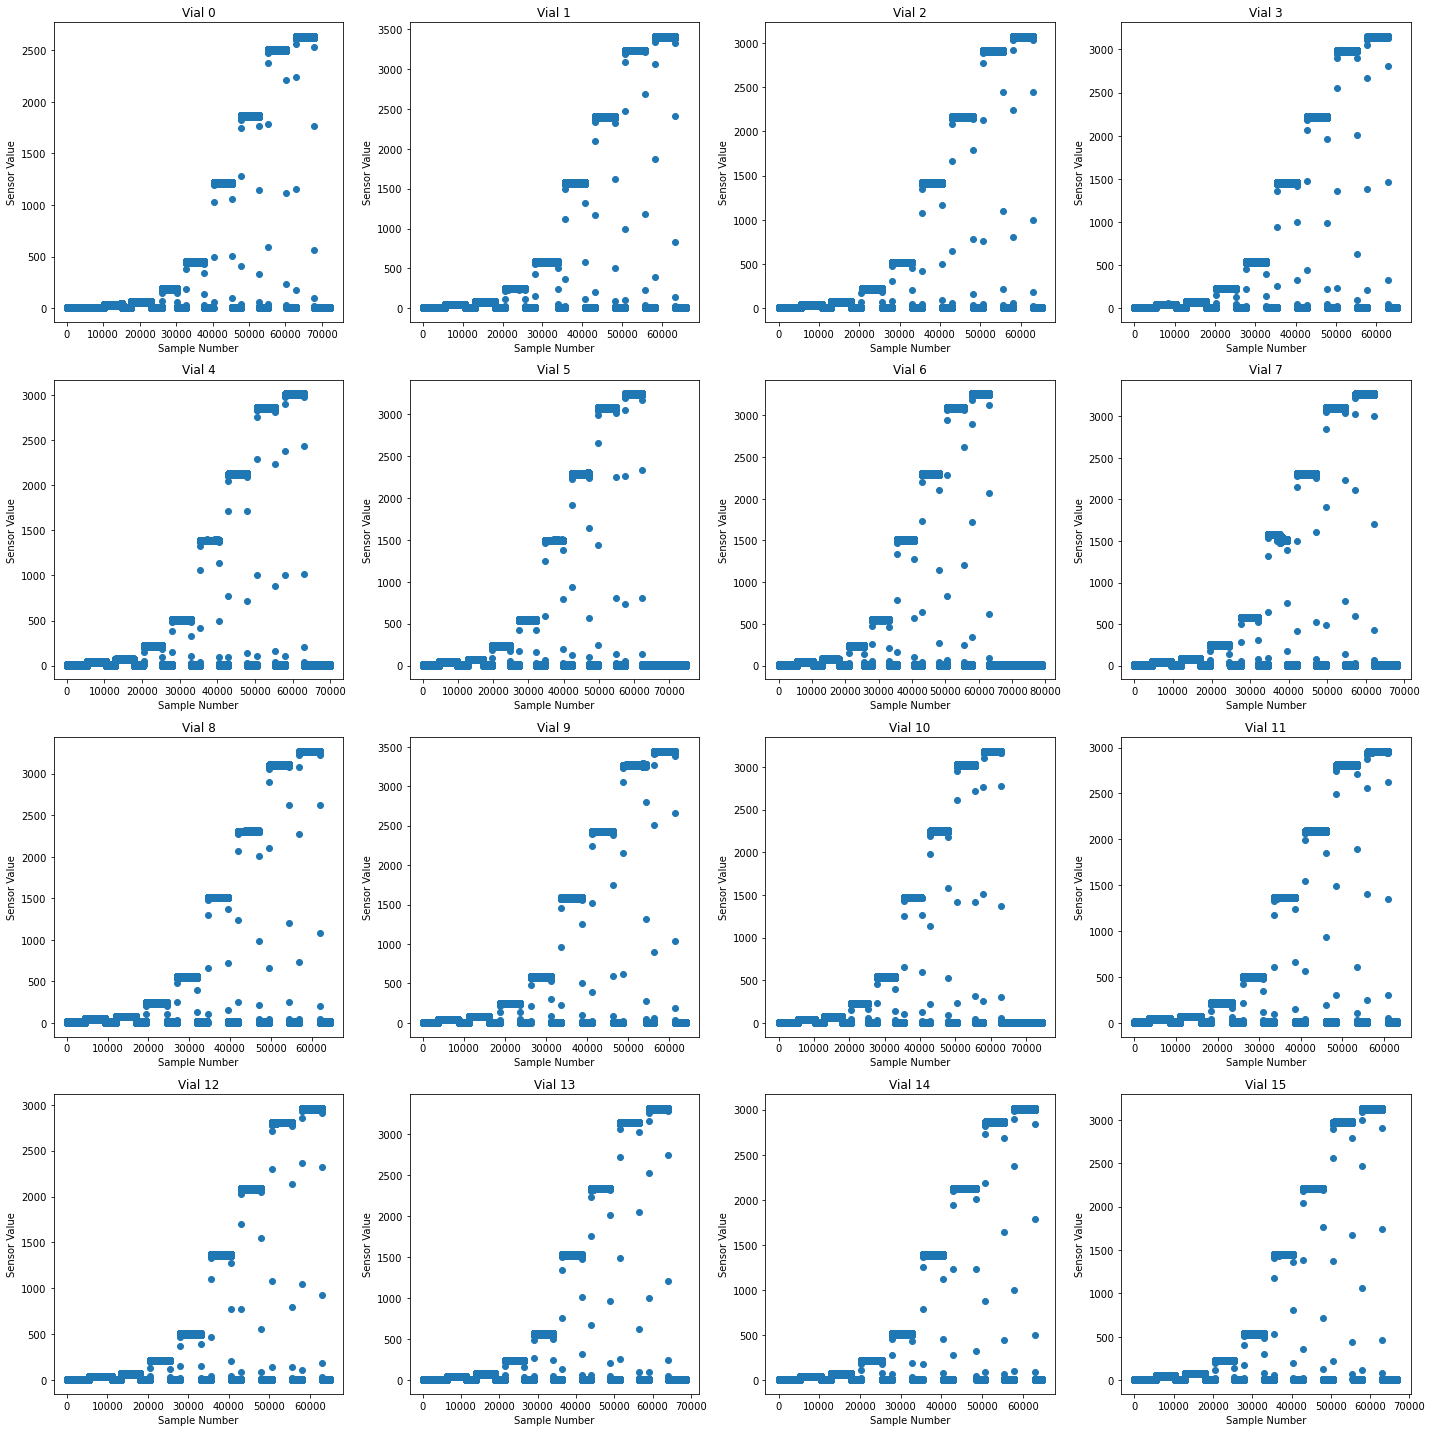

In [48]:
num_rows = int(np.ceil(np.sqrt(num_vials)))
num_cols = int(np.ceil(num_vials / num_rows))
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed
for i,v in enumerate(vial_nums):
    indices = np.array(rawDF[rawDF.vial == str(v)][indexname])
    values = np.array(rawDF[rawDF.vial == str(v)][valname])
    
    # Plot in a subplot
    if len(vial_nums) > 1:
        plt.subplot(num_rows, num_cols, i + 1)
    plt.plot(indices, values, 'o')
    plt.title(f'Vial {v}')
    plt.xlabel(indexname)
    plt.ylabel(valname)
plt.tight_layout()
plt.show()

# Subset by Value and Calibrate

## Find the Median of Each Vial and Produce a New DF

In [49]:
# Determine the number of rows and columns for the subplot grid
num_subsets = len(calibration_vals) # number of subsets
num_cols = int(np.ceil(np.sqrt(num_subsets)))
num_rows = int(np.ceil(num_subsets / num_cols))

# Make a new df 
copyDF = rawDF.copy(deep= True) #copying to avoid changing original
allgroupDFs = pd.DataFrame()
for i,v in enumerate(vial_nums):
    print(f'Vial {v}')
    # Subsetting
    df = copyDF[copyDF.vial == str(v)] # subset by vial
    try:
        df = subsetByIndex(df, threshold_var=valname, threshold=zeroThreshold, num_subsets=len(calibration_vals), subset_labels=calibration_vals,
                        min_length=min_length, reverse=True) # add subset column; start from highest values and go down
    except Exception as inst:
        print(f"Error: {inst}")
        continue

    if printAllPlots:
        plotGrid(df=df, subset=eVvalname, subset_names=calibration_vals, xVar=indexname, yVar=valname, subRows=num_rows, 
                    title=f'Vial {v}: ')
        
    # Get the median sensor value for each subset
    groupedDF = df.groupby([df[eVvalname], 'vial']).median() # group the dataframe by subset and take the median
    groupedDF = groupedDF.reset_index()
    groupedDF = groupedDF.rename(columns={valname:'Median Sensor Value'})
    # groupedDF = groupedDF[groupedDF[medvalname] < probeSaturated] # Remove saturated probe values
    allgroupDFs = pd.concat([allgroupDFs, groupedDF])

allgroupDFs

Vial 0
Vial 1
Vial 2
Vial 3
Vial 4
Vial 5
Vial 6
Vial 7
Vial 8
Vial 9
Vial 10
Vial 11
Vial 12
Vial 13
Vial 14
Vial 15


,eVOLVER PWM Value,vial,Sample Number,Median Sensor Value
0,2080,0,13224.5,41.769
1,2100,0,20412.5,62.287
2,2200,0,28189.0,190.760
3,2400,0,35247.5,446.790
4,3000,0,42754.5,1217.400
...,...,...,...,...
3,2400,15,30461.0,532.580
4,3000,15,37971.0,1446.500
5,3500,15,45482.0,2208.700
6,4000,15,53000.0,2971.000


## Plot Linear Fits of Each Vial

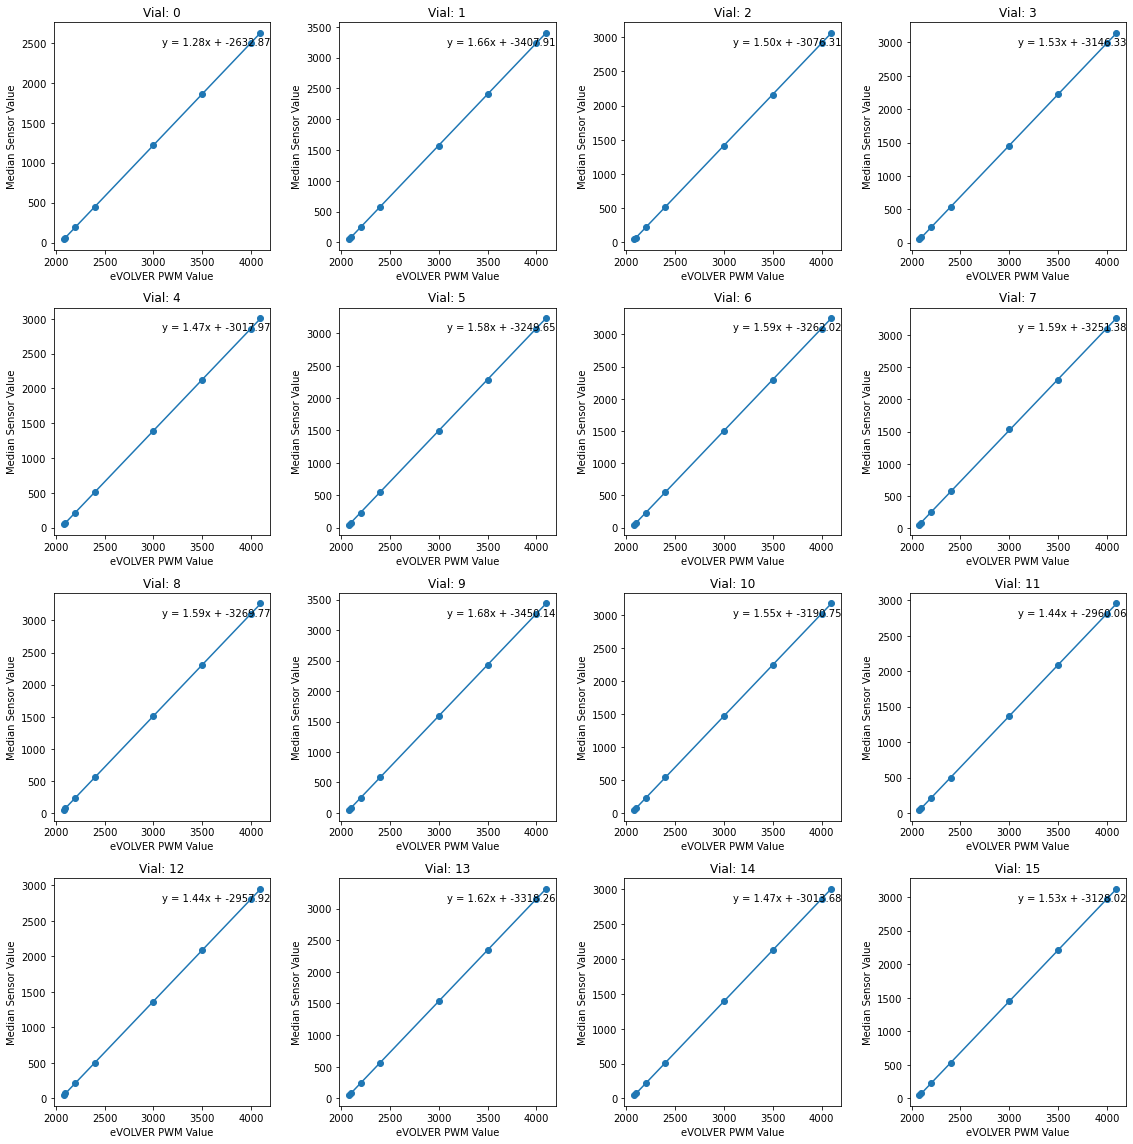

In [68]:
coefficients = [] # List to store the coefficients for each fit
plt.figure(figsize=(16, 16))  # Adjust the figure size as needed
num_cols = int(np.ceil(np.sqrt(len(vial_nums))))
num_rows = int(np.ceil(len(vial_nums) / num_cols))
# Loop through each vial
for i in vial_nums:
    thisDF = allgroupDFs[allgroupDFs['vial'] == str(i)]
    
    # Plot the median sensor values
    x = thisDF[eVvalname]
    y = thisDF[medvalname]
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(x,y)
    plt.title(f'Vial: {i}')
    plt.xlabel(eVvalname)
    plt.ylabel(medvalname)

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
    plt.annotate(f"y = {m:.2f}x + {b:.2f}", (0.5, 0.9), xycoords='axes fraction') # add annotation
    coefficients.append([round(m,4), round(b,4)])
    
plt.tight_layout()
# plt.suptitle('Median Sensor Values')
plt.show()

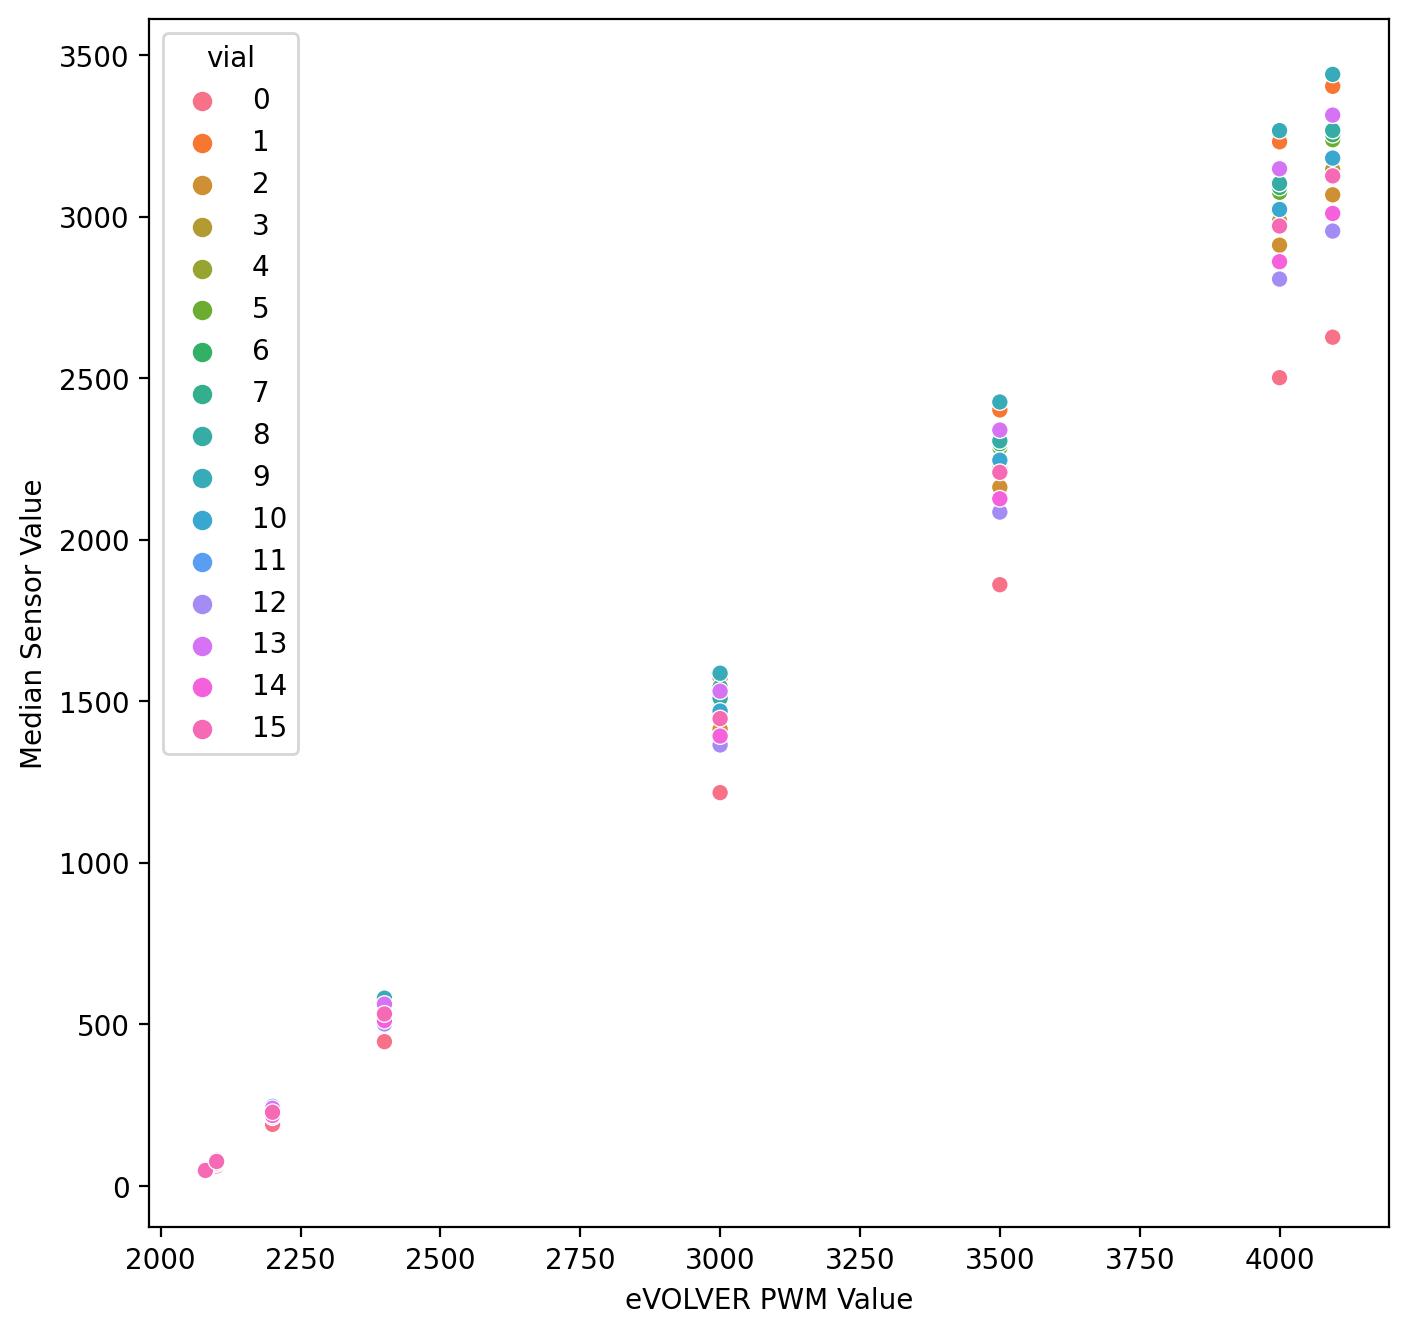

In [69]:
plt.figure(figsize=(8, 8), dpi=200)  # Adjust the figure size as needed
sns.scatterplot(data=allgroupDFs, x=eVvalname, y=medvalname, hue='vial')    
# plt.tight_layout()
plt.show()

# Save calibration values

In [73]:
calibration_filename = f'{fit_name}.txt'
print(coefficients)
np.savetxt(calibration_filename, coefficients, delimiter='\t')

[[1.2839, -2632.873], [1.6611, -3407.9132], [1.4981, -3076.3072], [1.5345, -3146.3296], [1.4701, -3017.9708], [1.5823, -3249.6537], [1.5892, -3262.0243], [1.591, -3251.3773], [1.5941, -3269.7743], [1.6803, -3450.1446], [1.5542, -3190.746], [1.443, -2960.0563], [1.4421, -2957.9198], [1.6176, -3318.2637], [1.4694, -3013.683], [1.5256, -3128.0165]]


## Double Check Your Calibration

In [71]:
light_cal = np.loadtxt(calibration_filename, delimiter="\t")
check_vals = [2100, 2500, 3500, 4095] # PWM values

for x in vial_nums:
    printout = {}
    for i in check_vals:
        printout[i] = round((float(i) * light_cal[x][0]) + light_cal[x][1], 2)
    print(f'Vial: {x}')
    print(printout)

Vial: 0
{2100: 63.32, 2500: 576.88, 3500: 1860.78, 4095: 2624.7}
Vial: 1
{2100: 80.4, 2500: 744.84, 3500: 2405.94, 4095: 3394.29}
Vial: 2
{2100: 69.7, 2500: 668.94, 3500: 2167.04, 4095: 3058.41}
Vial: 3
{2100: 76.12, 2500: 689.92, 3500: 2224.42, 4095: 3137.45}
Vial: 4
{2100: 69.24, 2500: 657.28, 3500: 2127.38, 4095: 3002.09}
Vial: 5
{2100: 73.18, 2500: 706.1, 3500: 2288.4, 4095: 3229.86}
Vial: 6
{2100: 75.3, 2500: 710.98, 3500: 2300.18, 4095: 3245.75}
Vial: 7
{2100: 89.72, 2500: 726.12, 3500: 2317.12, 4095: 3263.77}
Vial: 8
{2100: 77.84, 2500: 715.48, 3500: 2309.58, 4095: 3258.07}
Vial: 9
{2100: 78.49, 2500: 750.61, 3500: 2430.91, 4095: 3430.68}
Vial: 10
{2100: 73.07, 2500: 694.75, 3500: 2248.95, 4095: 3173.7}
Vial: 11
{2100: 70.24, 2500: 647.44, 3500: 2090.44, 4095: 2949.03}
Vial: 12
{2100: 70.49, 2500: 647.33, 3500: 2089.43, 4095: 2947.48}
Vial: 13
{2100: 78.7, 2500: 725.74, 3500: 2343.34, 4095: 3305.81}
Vial: 14
{2100: 72.06, 2500: 659.82, 3500: 2129.22, 4095: 3003.51}
Vial: 15
{210

In [72]:
light_cal = np.loadtxt(calibration_filename, delimiter="\t")
check_vals = [100, 200, 800, 1000] # light values in uE (or whatever units you are using)

for x in vial_nums:
    printout = {}
    for i in check_vals:
        printout[i] = int(round((float(i) - light_cal[x][1]) / light_cal[x][0], 2))
    print(f'Vial: {x}')
    print(printout)

Vial: 0
{100: 2128, 200: 2206, 800: 2673, 1000: 2829}
Vial: 1
{100: 2111, 200: 2172, 800: 2533, 1000: 2653}
Vial: 2
{100: 2120, 200: 2186, 800: 2587, 1000: 2720}
Vial: 3
{100: 2115, 200: 2180, 800: 2571, 1000: 2702}
Vial: 4
{100: 2120, 200: 2188, 800: 2597, 1000: 2733}
Vial: 5
{100: 2116, 200: 2180, 800: 2559, 1000: 2685}
Vial: 6
{100: 2115, 200: 2178, 800: 2556, 1000: 2681}
Vial: 7
{100: 2106, 200: 2169, 800: 2546, 1000: 2672}
Vial: 8
{100: 2113, 200: 2176, 800: 2553, 1000: 2678}
Vial: 9
{100: 2112, 200: 2172, 800: 2529, 1000: 2648}
Vial: 10
{100: 2117, 200: 2181, 800: 2567, 1000: 2696}
Vial: 11
{100: 2120, 200: 2189, 800: 2605, 1000: 2744}
Vial: 12
{100: 2120, 200: 2189, 800: 2605, 1000: 2744}
Vial: 13
{100: 2113, 200: 2174, 800: 2545, 1000: 2669}
Vial: 14
{100: 2119, 200: 2187, 800: 2595, 1000: 2731}
Vial: 15
{100: 2115, 200: 2181, 800: 2574, 1000: 2705}
